In [ ]:
import numpy as np
import pandas as pd
import os
import random
import sys
from tqdm import tqdm
from scipy.signal import resample


In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

<ipython-input-2-ec17af7b4eb3>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
!python -m pip install tensorflow_addons

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint
from scipy import stats
from sklearn.model_selection import train_test_split
import sklearn
import itertools

from keras import layers
from keras.layers import Input, Dense, Dropout, Activation, BatchNormalization, Add, Flatten, Reshape
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPool1D, ZeroPadding1D, LSTM, Bidirectional, Multiply
from keras.models import Sequential, Model
from sklearn.metrics import confusion_matrix

from tensorflow_addons.optimizers import CyclicalLearningRate

mpl.style.use('seaborn')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.0 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(
<ipython-input-3-34de20483826>:19: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  mpl.style.use('seaborn')


In [ ]:
## PTBXL
ptbxl_X = pd.read_csv('drive/MyDrive/이용섭/PTBXL_paced_X.csv')
ptbxl_Y = pd.read_csv('drive/MyDrive/이용섭/PTBXL_paced_Y.csv')

ptbxl_X.columns = ptbxl_X.columns.astype(int)
ptbxl_Y.columns=[0]

ptbxl_Y[0].value_counts()

1.0    294
0.0    294
Name: 0, dtype: int64

In [ ]:
# train test split
ptbxlNonPacedTest = ptbxl_Y[ptbxl_Y[0] == 0].sample(frac=0.8, random_state=0)
ptbxlPacedTest = ptbxl_Y[ptbxl_Y[0] == 1].sample(frac=0.8, random_state=0)

ptbxl_trainY = pd.concat([ptbxlNonPacedTest, ptbxlPacedTest])
ptbxl_trainX = ptbxl_X.loc[ptbxl_trainY.index]

ptbxl_testY = ptbxl_Y.loc[~ptbxl_Y.index.isin(ptbxl_trainY.index)]
ptbxl_testX = ptbxl_X.loc[ptbxl_testY.index]


In [ ]:
## lobachevsky

lobachevsky_X = pd.read_csv('drive/MyDrive/이용섭/lobachevsky_X.csv')
lobachevsky_Y = pd.read_csv('drive/MyDrive/이용섭/lobachevsky_Y.csv')

lobachevsky_X.columns = lobachevsky_X.columns.astype(int)
lobachevsky_Y.columns=[0]

lobachevsky_Y[0].value_counts()

1.0    10
0.0    10
Name: 0, dtype: int64

In [ ]:
# train test split

lobachevskyNonPacedTest = lobachevsky_Y[lobachevsky_Y[0] == 0].sample(frac=0.8, random_state=0)
lobachevskyPacedTest = lobachevsky_Y[lobachevsky_Y[0] == 1].sample(frac=0.8, random_state=0)

lobachevsky_trainY = pd.concat([lobachevskyNonPacedTest, lobachevskyPacedTest])
lobachevsky_trainX = lobachevsky_X.loc[lobachevsky_trainY.index]

lobachevsky_testY = lobachevsky_Y.loc[~lobachevsky_Y.index.isin(lobachevsky_trainY.index)]
lobachevsky_testX = lobachevsky_X.loc[lobachevsky_testY.index]


In [ ]:
##mitdb
mitdb_data = np.load('drive/MyDrive/이용섭/mitdb_data.npy')
mitdb_group = np.load('drive/MyDrive/이용섭/mitdb_group.npy')

mitdb_train_ind = np.load('drive/MyDrive/이용섭/mitdb_train_ind.npy')
mitdb_test_ind = np.load('drive/MyDrive/이용섭/mitdb_test_ind.npy')

train_input = pd.DataFrame(mitdb_data[mitdb_train_ind])
test_input = pd.DataFrame(mitdb_data[mitdb_test_ind])

train_target = pd.DataFrame(mitdb_group[mitdb_train_ind])
test_target = pd.DataFrame(mitdb_group[mitdb_test_ind])

train_target.loc[train_target[0] != 'P', 0] = 0
train_target.loc[train_target[0] == 'P', 0] = 1

test_target.loc[test_target[0] != 'P', 0] = 0
test_target.loc[test_target[0] == 'P', 0] = 1

In [ ]:
train_target[0].value_counts(), test_target[0].value_counts()

(0    82192
 1     2067
 Name: 0, dtype: int64,
 0    18447
 1     1790
 Name: 0, dtype: int64)

In [ ]:
## training set sampling
non_paced_X = train_input[train_target[0] == 0].sample(n=2067, random_state=0)
paced_X = train_input[train_target[0] == 1]

X = pd.concat([non_paced_X, paced_X])
Y = train_target.loc[X.index]

train_input = X.reset_index(drop=True)
train_target = Y.reset_index(drop=True)

In [ ]:
train_target[0].value_counts(), test_target[0].value_counts()

(0    2067
 1    2067
 Name: 0, dtype: int64,
 0    18447
 1     1790
 Name: 0, dtype: int64)

In [ ]:
train_input = pd.concat([train_input, ptbxl_trainX, lobachevsky_trainX]).reset_index(drop=True)
train_target = pd.concat([train_target, ptbxl_trainY, lobachevsky_trainY]).reset_index(drop=True)

test_input = pd.concat([test_input, ptbxl_testX, lobachevsky_testX]).reset_index(drop=True)
test_target = pd.concat([test_target, ptbxl_testY, lobachevsky_testY]).reset_index(drop=True)

train_target[0].value_counts(), test_target[0].value_counts()

(0    2310
 1    2310
 Name: 0, dtype: int64,
 0    18508
 1     1851
 Name: 0, dtype: int64)

### NK2

In [ ]:
import scipy

def signal_clean(signal, sampling_rate=125):
  # highpass_filter
  sos = scipy.signal.butter(5, 0.5, btype='highpass', output="sos", fs=sampling_rate)
  filtered = scipy.signal.sosfiltfilt(sos, signal)

  #powerline filter
  b = np.ones(int(sampling_rate / 50))
  a = [len(b)]
  y = scipy.signal.filtfilt(b, a, filtered, method="pad")

  return y

In [ ]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

In [ ]:
train_filtered = signal_clean(train_input)
train_filtered = pd.DataFrame(train_filtered).T
train_input = pd.DataFrame(std_scaler.fit_transform(train_filtered)).T

test_filtered = signal_clean(test_input)
test_filtered = pd.DataFrame(test_filtered).T

test_input = pd.DataFrame(std_scaler.fit_transform(test_filtered)).T

### LPF+BWR

In [ ]:
!python -m pip install heartpy

import heartpy as hp
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

train_filtered = hp.filtering.filter_signal(train_input, cutoff = 10, sample_rate = 125, order = 3, filtertype='lowpass')
train_filtered = hp.filtering.filter_signal(train_filtered, cutoff = 0.05, sample_rate = 125, order = 3, filtertype='notch')
train_filtered = pd.DataFrame(train_filtered).T

train_input = pd.DataFrame(std_scaler.fit_transform(train_filtered)).T

std_scaler = StandardScaler()

test_filtered = hp.filtering.filter_signal(test_input, cutoff = 10, sample_rate = 125, order = 3, filtertype='lowpass')
test_filtered = hp.filtering.filter_signal(test_filtered, cutoff = 0.05, sample_rate = 125, order = 3, filtertype='notch')
test_filtered = pd.DataFrame(test_filtered).T

test_input = pd.DataFrame(std_scaler.fit_transform(test_filtered)).T


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
train_input = np.array(train_input).reshape(-1, 1250, 1)
test_input = np.array(test_input).reshape(-1, 1250, 1)

train_input = train_input.astype(float)
test_input = test_input.astype(float)

train_target = np.array(train_target)
test_target = np.array(test_target)

train_target = train_target.astype(float)
test_target = test_target.astype(float)

In [ ]:
def ResidualBlock(x, filters, kernel_size, strides):
    x_shortcut = x
    x = Conv1D(filters = filters, kernel_size = kernel_size, strides = strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters = filters, kernel_size = kernel_size, strides = strides, padding='same')(x)

    x = SE_Block(x, filters)

    out = Add()([x, x_shortcut])
    out = Activation('relu')(out)
    return out

def convolution_Block(x, filters, kernel_size, strides):
    x_shortcut = x

    x = Conv1D(filters = filters, kernel_size = kernel_size, strides = strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.2)(x)
    x = Conv1D(filters = filters, kernel_size = kernel_size, strides = 2, padding='same')(x)

    x_shortcut = Conv1D(filters = filters, kernel_size = kernel_size, strides = 2, padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)
    x_shortcut = Activation('relu')(x_shortcut)
    x_shortcut = Dropout(0.2)(x_shortcut)

    out = Add()([x, x_shortcut])
    out = Activation('relu')(out)

    return out

def SE_Block(x, filters):
    input = x

    output = GlobalAveragePooling1D()(input)
    output = Dense(filters, activation='relu')(output)
    output = Dense(filters, activation='sigmoid')(output)

    scale = Multiply()([input, output])

    return scale

def SE_Resnet_34(input_shape):
    input = Input(input_shape)
    x = input

    x = Conv1D(filters = 64, kernel_size = 7, strides = 2, activation = 'relu', padding='same')(x)
    x = MaxPool1D(pool_size = 2, strides=2, padding='same')(x)

    x = ResidualBlock(x, 64, 3, 1)
    x = ResidualBlock(x, 64, 3, 1)
    x = ResidualBlock(x, 64, 3, 1)

    x = convolution_Block(x, 128, 1, 1)
    x = ResidualBlock(x, 128, 3, 1)
    x = ResidualBlock(x, 128, 3, 1)
    x = ResidualBlock(x, 128, 3, 1)

    x = convolution_Block(x, 256, 1, 1)
    x = ResidualBlock(x, 256, 3, 1)
    x = ResidualBlock(x, 256, 3, 1)
    x = ResidualBlock(x, 256, 3, 1)
    x = ResidualBlock(x, 256, 3, 1)
    x = ResidualBlock(x, 256, 3, 1)

    x = convolution_Block(x, 512, 1, 1)
    x = ResidualBlock(x, 512, 3, 1)
    x = ResidualBlock(x, 512, 3, 1)

    #x = MaxPool1D(pool_size = 2, padding='same')(x)
    x = GlobalAveragePooling1D()(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(input, output)

    return model

In [ ]:
SE_model_34 = SE_Resnet_34(input_shape = (1250,1))

N = train_input.shape[0]
batch_size = 16
iterations = N/batch_size
step_size= 2 * iterations

lr_schedule = CyclicalLearningRate(1e-6, 1e-3, step_size=step_size, scale_fn=lambda x: tf.pow(0.95,x))
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

save_best_weights = ModelCheckpoint(filepath='drive/MyDrive/이용섭/models/SE_resnet_34_paced_smallBatch.hdf5',save_best_only=True, monitor='loss')
SE_model_34.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
history = SE_model_34.fit(train_input, train_target, shuffle=True, batch_size=batch_size, epochs=100, callbacks=[save_best_weights])

SE_model_34.save("drive/MyDrive/이용섭/models/SE_resnet_34_paced_smallBatch.h5")

Epoch 1/100
289/289 [==============================] - 62s 66ms/step - loss: 0.2299 - accuracy: 0.9110
Epoch 2/100
289/289 [==============================] - 17s 59ms/step - loss: 0.1066 - accuracy: 0.9716
Epoch 3/100
289/289 [==============================] - 21s 74ms/step - loss: 0.0942 - accuracy: 0.9701
Epoch 4/100
289/289 [==============================] - 17s 57ms/step - loss: 0.0609 - accuracy: 0.9827
Epoch 5/100
289/289 [==============================] - 17s 59ms/step - loss: 0.0570 - accuracy: 0.9840
Epoch 6/100
289/289 [==============================] - 18s 61ms/step - loss: 0.0696 - accuracy: 0.9792
Epoch 7/100
289/289 [==============================] - 15s 51ms/step - loss: 0.0772 - accuracy: 0.9788
Epoch 8/100
289/289 [==============================] - 16s 56ms/step - loss: 0.0490 - accuracy: 0.9864
Epoch 9/100
289/289 [==============================] - 17s 57ms/step - loss: 0.0451 - accuracy: 0.9877
Epoch 10/100
289/289 [==============================] - 15s 52ms/step - l

In [ ]:
### ROC curve

from sklearn.metrics import roc_curve
from sklearn import metrics
def plot_roc_curve(fper, tper):
    plt.plot(fper, tper, color='red', label='ROC')
    plt.plot([0, 1], [0, 1], color='green', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend()
    plt.show()

In [ ]:
### confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score
from sklearn.preprocessing import Binarizer
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    #thresholds list 객체 내의 값을 iteration 하면서 평가 수행

    result = []
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)

        result_list =  get_clf_eval(y_test, custom_predict) + [custom_threshold]
        result.append(result_list)
    return result
def get_clf_eval(y_test, pred):
    confusion = confusion_matrix(y_test, pred)
    #accuracy = accuracy_score(y_test, pred)
    #precision = precision_score(y_test, pred)
    #recall = recall_score(y_test, pred)
    tp = confusion[1][1]
    fn = confusion[1][0]
    fp = confusion[0][1]
    tn = confusion[0][0]
    specificity = tn/(fp+tn)
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    accuracy = (tp+tn)/(tp+tn+fp+fn)
    # F1 스코어 추가
    f1 = f1_score(y_test, pred)
    # F1 score print 추가

    return [accuracy, precision, recall, specificity, f1]



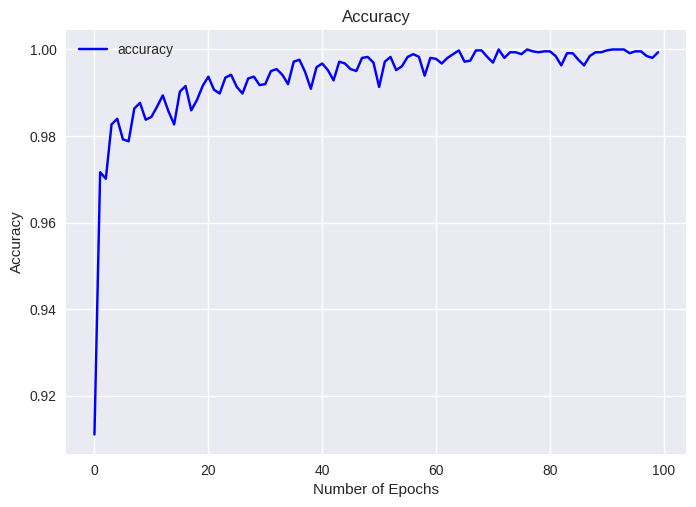

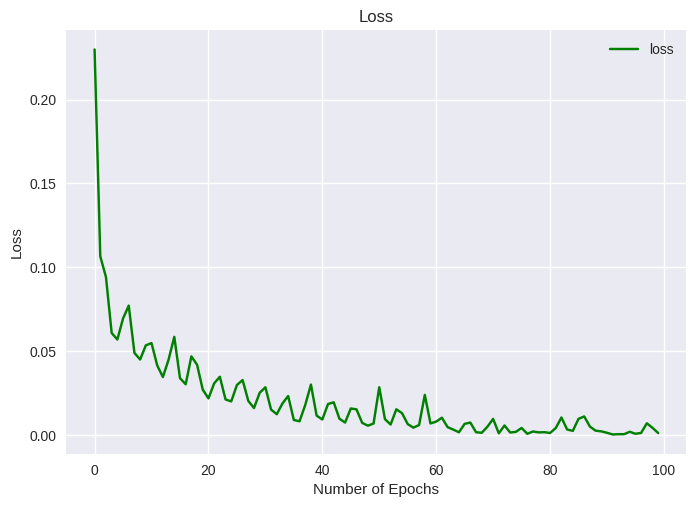

In [ ]:
# Plot the loss and accuracy curves for training and validation
plt.plot(history.history['accuracy'], color='b', label="accuracy")

plt.title("Accuracy")
plt.xlabel("Number of Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.subplots()
plt.plot(history.history['loss'], color='g', label="loss")

plt.title("Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()

plt.show()

In [ ]:
SE_model_34.load_weights("drive/MyDrive/이용섭/models/SE_resnet_34_paced_smallBatch.hdf5")

637/637 [==============================] - 10s 13ms/step
0.990386521716134


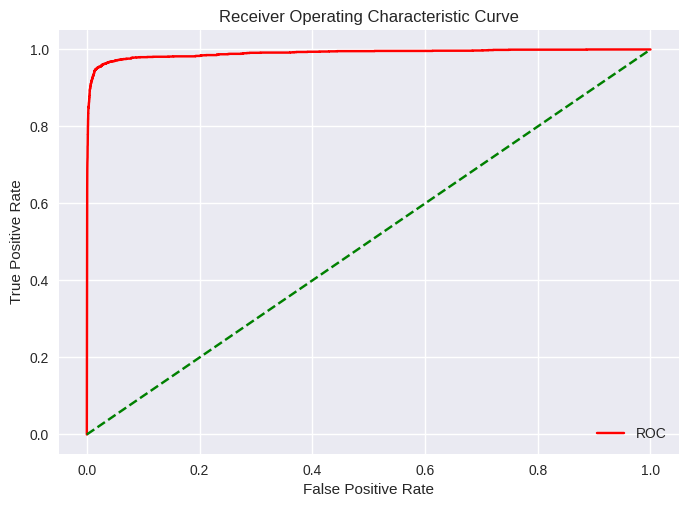

In [ ]:
## roc curve

prob = SE_model_34.predict(test_input)
fper, tper, thresholds = roc_curve(test_target, prob)
print(metrics.auc(fper, tper))
plot_roc_curve(fper, tper)


Confusion matrix, without normalization
[[18348   160]
 [  150  1701]]


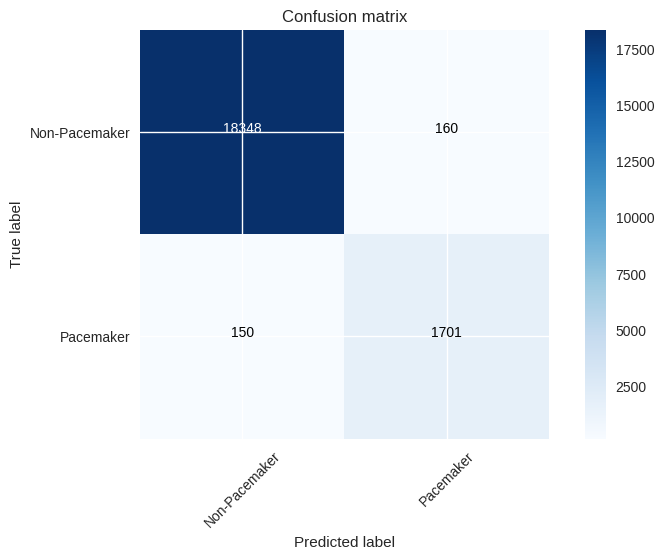

In [ ]:
## confusion matrix

y_pred = (prob > 0.5).astype("int32")
# Compute confusion matrix
cnf_matrix = sklearn.metrics.confusion_matrix(test_target, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Non-Pacemaker', 'Pacemaker'],
                      title='Confusion matrix')

In [ ]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
pred_proba = prob
resultByThreshold = get_eval_by_threshold(test_target, pred_proba.reshape(-1, 1), thresholds)

round(pd.DataFrame(resultByThreshold, columns = ['Accuracy', 'PPV', 'Sensitivity', 'Specificity', 'F1 score', 'Threshold']).set_index('Threshold').T, 4)

Threshold,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
Accuracy,0.9824,0.9831,0.9839,0.9844,0.9848,0.9851,0.9851,0.9855,0.9855
PPV,0.8715,0.8870,0.8989,0.9071,0.9140,0.9197,0.9239,0.9313,0.9405
Sensitivity,0.9454,0.9330,0.9271,0.9233,0.9190,0.9163,0.9114,0.9076,0.8968
Specificity,0.9861,0.9881,0.9896,0.9905,0.9914,0.9920,0.9925,0.9933,0.9943
F1 score,0.9070,0.9094,0.9128,0.9151,0.9165,0.9180,0.9176,0.9193,0.9181
